<div style="background-color: white; border: 2px solid black; border-radius: 20px; padding: 15px 25px; display: inline-block; color: black;">
<font face='Liberation serif' size=3>
    
#### **Привет, Руслан!** 👋

---

Меня зовут Артём Пиляй. Я буду проверять твой проект «*Исследование рынка заведений общественного питания Москвы*» ☕.

---

В рамках корпоративной этики мы общаемся на «ты». Но если лучше на «Вы», то важно обозначить это сразу.

---

Комментарии к проекту размещены в отдельных ячейках Markdown. Для удобства они отображаются в меню **Contents** слева. 

Я использую четыре типа комментариев:

---

✅ Главый комментарий — значит, всё сделано хорошо. А ещё здесь могут быть подсказки, как улучшить проект.

---

⚠️ Рекомендуемый к исправлению — лучше внести правки, хотя это не критично для текущего проекта.

---

⛔ Обязателен к исправлению — важный комментарий, который нужно доработать, чтобы проект прошёл проверку.

---

🚩 Красный флаг — проверку пришлось прервать, так как действие в ячейке выше повлияло на весь дальнейший проект.
    
<br>    

---

Важно:
    
- Не перемещать и не удалять мои комментарии. Если они будут удалены, я верну последнюю версию проекта, где они сохранились.
    
- Если возникнут вопросы, их можно задавать прямо в конце моих комментариев, которые отмечены ⚠️, ⛔ или 🚩 - под чертой. Комментарии, отмеченные ✅, я повторно не смотрю. Например:
    
<!-- ✅⚠️⛔❌🚩 -->
<div style="background-color: white; border: 2px solid black; border-radius: 20px; padding: 15px 25px; display: inline-block; color: black;">
   
⚠️ **Критерий проверки**
    
---
    
⚠️ Мой комментарий
    
---    

**Здесь можно оставить комментарий**


</div>

🏁 [Перейти к итогам ревью](#results)

<a id="start"></a>

# Разработка A/B-тестирования и анализ результатов

Вы работаете продуктовым аналитиком в компании, которая разрабатывает развлекательное приложение с функцией «бесконечной» ленты, как, например, в приложениях с короткими видео. В вашем приложении существует две модели монетизации: первая — ежемесячная платная подписка, которая позволяет пользователям смотреть ленту без рекламы, вторая — демонстрация рекламы для пользователей, которые ещё не оформили подписку.

Команда разработчиков рекомендательных систем создала новый алгоритм рекомендаций, который, по их мнению, будет показывать более интересный контент для каждого пользователя. Вас, как аналитика, просят помочь рассчитать параметры A/B-теста, который позволит проверить эту гипотезу, и проанализировать его результаты.

## Описание данных

Вы будете работать с тремя таблицами:

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-11 по 2025-09-23. Путь к файлу: `/datasets/sessions_project_history.csv`.

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. Путь к файлу: `/datasets/sessions_project_test_part.csv`.

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. Путь к файлу: `/datasets/sessions_project_test.csv`.

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).


## Что нужно сделать
Ваши задачи: рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента.

<!-- ✅⚠️⛔❌🚩 -->
<div style="background-color: white; border: 2px solid black; border-radius: 20px; padding: 15px 25px; display: inline-block; color: black;">

##### ✅ Вводная часть

---
    
✅ Отлично, что уже есть вводная часть написанная в шаблоне.

---

⚠️ Еще можно раскрыть особенности А/В теста — изменение какой метрики ожидается, какие другие метрики будут также тестироваться и какой ожидаемый эффект
    
Это небольшое улучшение, которое сделают проект более презентабельным и понятным для заказчика. 😉    
    
---
    
💬 Здесь можно оставить комментарий

### 1. Работа с историческими данными (EDA)

#### 1.1. Загрузка исторических данных
На первом этапе поработайте с историческими данными приложения:

- Импортируйте библиотеку pandas.

- Считайте и сохраните в датафрейм `sessions_history` CSV-файл с историческими данными о сессиях пользователей `sessions_project_history.csv`.

Выведите на экран первые пять строк полученного датафрейма.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
from math import ceil
from scipy import stats as st
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest

<!-- ✅⚠️⛔❌🚩 -->
<div style="background-color: white; border: 2px solid black; border-radius: 20px; padding: 15px 25px; display: inline-block; color: black;">
    
##### ✅ Python Enhancement Proposal №8.
    
---    

⚠️ Я понимаю, что в прекоде импорты идут дальше, но согласно руководству PEP 8 лучше:
- ✅ отделять импорт от основного кода;
- ❌ импортировать все библиотеки в одной ячейке в начале проекта.  

Это делает код более структурированным и понятным.

Это помогает:
- Сразу видеть, какое окружение необходимо для запуска проекта.
- Избежать дублирования импортов в разных частях кода.
- Облегчить отладку и переносимость проекта.
    
Подробнее о PEP 8 можно прочитать в статье [*PEP 8 - руководство по написанию кода на Python*](https://pythonworld.ru/osnovy/pep-8-rukovodstvo-po-napisaniyu-koda-na-python.html).    
    
---
    
💬 Здесь можно оставить комментарий

    
---
    
✅ Отлично, не забвай про этот стандарт и в будущем.        

In [2]:
try:
    df = pd.read_csv("https://code.s3.yandex.net/datasets/sessions_project_history.csv")
    print("Файл успешно загружен")
    print(f"Размер данных: {df.shape}")
    
except FileNotFoundError:
    print("Ошибка: Файл не найден! Проверьте путь к файлу.")
    
display(df.head(5))

Файл успешно загружен
Размер данных: (435924, 10)


,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


#### 1.2. Знакомство с данными
- Для каждого уникального пользователя `user_id` рассчитайте количество уникальных сессий `session_id`.

- Выведите на экран все данные из таблицы `sessions_history` для одного пользователя с наибольшим количеством сессий. Если таких пользователей несколько, выберите любого из них.

- Изучите таблицу для одного пользователя, чтобы лучше понять логику формирования каждого столбца данных.



In [3]:
df_grouped = df.groupby('user_id')['session_id'].nunique().sort_values(ascending = False)
df_max = df_grouped.max()
users_with_max = df_grouped[df_grouped == df_max].index
selected_user = users_with_max[0]
result = df[df['user_id'] == selected_user]
display(result)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


<!-- ✅⚠️⛔❌🚩 -->
<div style="background-color: white; border: 2px solid black; border-radius: 20px; padding: 15px 25px; display: inline-block; color: black;">

##### ✅ Знакомство с данными

---    
    
✅  В таких случаях можно использовать `.value_counts().idxmax()`, чтобы динамически определять наиболее частый `user_id`.

`idmax` помогает упростить и ускорить анализ данных.

Преимущества метода:
- Оптимизация кода — сокращает количество вычислений по сравнению с альтернативными методами.
- Быстродействие — позволяет находить нужное значение без дополнительной сортировки.
- Читаемость — код становится лаконичным и понятным.
- Эффективность — снижает нагрузку при обработке больших объемов данных.

Подробнее можно ознакомиться в документации по Pandas: [Pandas idxmax()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.idxmax.html)

#### 1.3. Анализ числа регистраций
Одна из важнейших метрик продукта — число зарегистрированных пользователей. Используя исторические данные, визуализируйте, как менялось число регистраций в приложении за время его существования.

- Агрегируйте исторические данные и рассчитайте число уникальных пользователей и число зарегистрированных пользователей для каждого дня наблюдения. Для простоты считайте, что у пользователя в течение дня бывает одна сессия максимум и статус регистрации в течение одного дня не может измениться.

- Постройте линейные графики общего числа пользователей и общего числа зарегистрированных пользователей по дням. Отобразите их на одном графике.

- Постройте отдельный линейный график доли зарегистрированных пользователей от всех пользователей по дням.

- На обоих графиках должны быть заголовок, подписанные оси X и Y, сетка и легенда.

In [4]:
df_date = df.groupby('session_date')['user_id'].nunique()
df_date = df_date.sort_index()
display(df_date)

session_date
2025-08-11     3919
2025-08-12     6056
2025-08-13     8489
2025-08-14    10321
2025-08-15    14065
2025-08-16    12205
2025-08-17    11200
2025-08-18    10839
2025-08-19    12118
2025-08-20    13514
2025-08-21    15051
2025-08-22    17563
2025-08-23    16082
2025-08-24    13683
2025-08-25    13635
2025-08-26    13289
2025-08-27    14766
2025-08-28    15388
2025-08-29    16873
2025-08-30    14891
2025-08-31    13266
2025-09-01    12685
2025-09-02    12672
2025-09-03    12777
2025-09-04    13683
2025-09-05    15324
2025-09-06    13078
2025-09-07    12367
2025-09-08    11826
2025-09-09    11780
2025-09-10    12526
2025-09-11     8623
2025-09-12     6436
2025-09-13     5183
2025-09-14     4364
2025-09-15     3698
2025-09-16     3032
2025-09-17     2548
2025-09-18     1952
2025-09-19     1418
2025-09-20     1100
2025-09-21      776
2025-09-22      546
2025-09-23      317
Name: user_id, dtype: int64

In [5]:
df_reg = df.groupby('session_date')['registration_flag'].sum()
df_reg = df_reg.sort_index()
display(df_reg)

session_date
2025-08-11     169
2025-08-12     336
2025-08-13     464
2025-08-14     625
2025-08-15     840
2025-08-16     916
2025-08-17     833
2025-08-18     860
2025-08-19     831
2025-08-20    1008
2025-08-21    1063
2025-08-22    1251
2025-08-23    1253
2025-08-24    1181
2025-08-25    1060
2025-08-26    1050
2025-08-27    1076
2025-08-28    1175
2025-08-29    1174
2025-08-30    1165
2025-08-31    1105
2025-09-01    1028
2025-09-02    1039
2025-09-03    1035
2025-09-04    1007
2025-09-05    1030
2025-09-06    1023
2025-09-07    1069
2025-09-08    1009
2025-09-09     980
2025-09-10    1015
2025-09-11     824
2025-09-12     669
2025-09-13     537
2025-09-14     440
2025-09-15     383
2025-09-16     286
2025-09-17     272
2025-09-18     201
2025-09-19     132
2025-09-20     107
2025-09-21      87
2025-09-22      68
2025-09-23      32
Name: registration_flag, dtype: int64

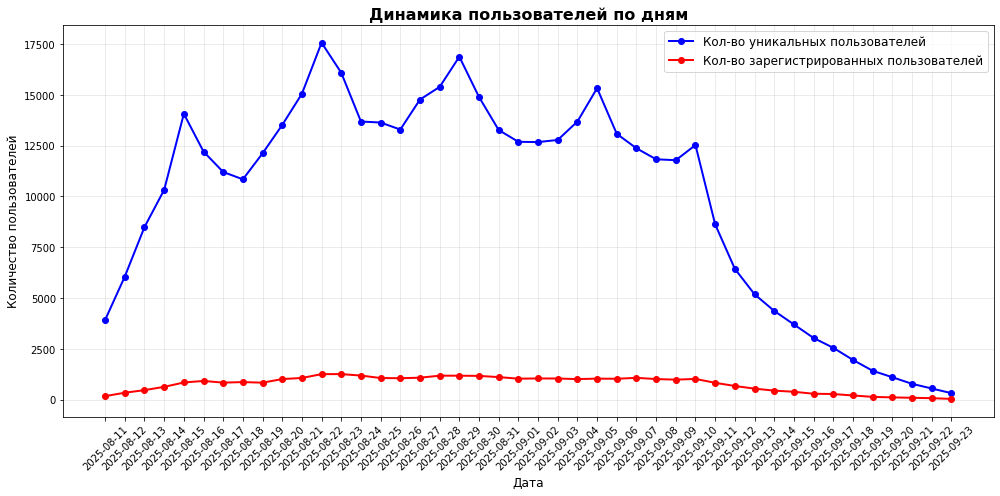

In [6]:
plt.figure(figsize=(14, 7))

plt.plot(df_date.index, df_date.values, 
         label='Кол-во уникальных пользователей', 
         marker='o', 
         linewidth=2,
         color='blue')

plt.plot(df_reg.index, df_reg.values, 
         label='Кол-во зарегистрированных пользователей', 
         marker='o', 
         linewidth=2,
         color='red')

# Настройки графика
plt.title('Динамика пользователей по дням', fontsize=16, fontweight='bold')
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Количество пользователей', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

<div class="alert alert-block alert-success">
    
Комментарии к графику: 
    
На графике наблюдаются как подъемы так и падения кол-ва уникальных пользователей, что говорит о общей нестабильности измеряемой величины.
    
Подъемы наблюдаются в даты: 14.08.2025, 21.08.2025, 28.08.2025, 04.09.2025, 09.09.2025. Можно заметить, что все эти даты являются четвергами. 
    
Помимо этого можно заметить, что общее кол-во уникальных и зарегистрированных пользователей падает к концу наблюдаемого периода.

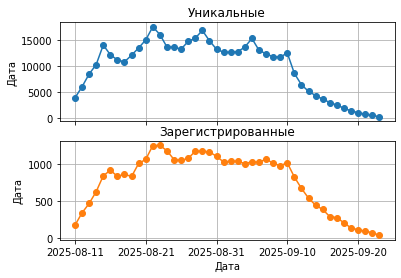

In [7]:
df_agg = df.groupby('session_date').agg({'user_id' : 'nunique', 'registration_flag' : 'sum'})
axes = df_agg.plot(kind='line',
                   subplots=True,
                   sharex=True,
                   sharey=False,
                   legend=False,
                   marker='o', # Установка маркера для точек
                   title=['Уникальные', 'Зарегистрированные'])

# Устанавливаем подпись для оси Y каждого из подграфиков
axes[0].set_ylabel('Дата')
axes[1].set_ylabel('Дата')

# Включаем сетку для каждого из подграфиков
axes[0].grid(which='both')
axes[1].grid(which='both')

# Подписываем ось X
plt.xlabel('Дата')
plt.show()

<div class="alert alert-block alert-success">
    

__Комментарий от студента__
Сделал subplots для своего понимания

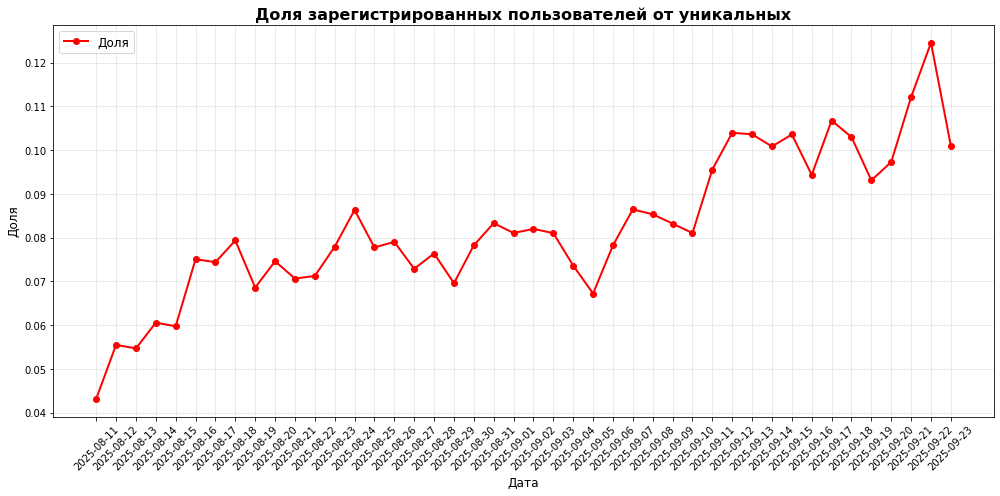

In [8]:
df_part = df_reg / df_date
plt.figure(figsize=(14, 7))

plt.plot(df_part.index, df_part.values, 
         label='Доля', 
         marker='o', 
         linewidth=2,
         color='red')

# Настройки графика
plt.title('Доля зарегистрированных пользователей от уникальных', fontsize=16, fontweight='bold')
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Доля', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

<div class="alert alert-block alert-success">

Комментарии к графику:

Как видно на графике выше, доля зарегистрированных пользователей от уникальных стремительно растет. 

На момент начала наблюдаемого периода эта доля составляла около 0.04, когда на конец периода она возросла до 0.1. 

Смотря на график, можно сделать вывод, что данный рост не является стабильным - видны резкие спады и подъемы наблюдаемой метрики.

<!-- ✅⚠️⛔❌🚩 -->
<div style="background-color: white; border: 2px solid black; border-radius: 20px; padding: 15px 25px; display: inline-block; color: black;">

##### ✅ Анализ числа регистраций

---

✅ Расчет числа регистраций выполнен верно. 



---
    
⚠️ Нет самого анализа — цель шага «Анализ числа регистраций» не достигнута. Представлен только код, но не сделаны выводы. Лучше добавить хотя бы 2–3 предложения с интерпретацией — например, как менялось число регистраций, есть ли пики, спады, насколько стабильно. 
    
Выводы — ключевой этап работы аналитика, это интерпретация результатов исследования. Представь врача, который осматривает пациента, но не ставит диагноз и не назначает лечение. Какую ценность он тогда приносит?

Например, в задании «**Доля пользователей, просмотревших более четырёх страниц**» изучена динамика метрики, на которую направлен A/B-тест. Это ключевой момент в исследовании исторических данных, и без выводов он теряет аналитическую ценность.

То же самое касается графиков: без объяснений они превращаются в обычные изображения, которые не несут смысла.

---

💬 Здесь можно оставить комментарий
    
✅ Важно учитывать, что высокая вариативность доли может быть связана с уменьшением количества наблюдений к концу периода.    

#### 1.4. Анализ числа просмотренных страниц
Другая важная метрика продукта — число просмотренных страниц в приложении. Чем больше страниц просмотрено, тем сильнее пользователь увлечён контентом, а значит, выше шансы, что он зарегистрируется и оплатит подписку.

- Найдите количество сессий для каждого значения количества просмотренных страниц. Например: одну страницу просмотрели в 29 160 сессиях, две страницы — в 105 536 сессиях и так далее.

- Постройте столбчатую диаграмму, где по оси X будет число просмотренных страниц, по оси Y — количество сессий.

- На диаграмме должны быть заголовок, подписанные оси X и Y.

In [9]:
df_page = df.groupby('page_counter')['session_id'].nunique()
display(df_page)

page_counter
1     29160
2    105536
3    166690
4    105569
5     26288
6      2589
7        92
Name: session_id, dtype: int64

<AxesSubplot:title={'center':'Число просмотренных страниц'}, xlabel='page_counter', ylabel='Кол-во сессий'>

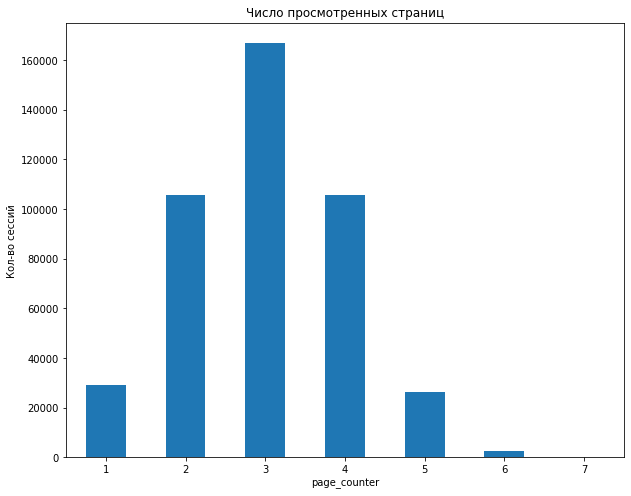

In [10]:
df_page.plot(
    kind = 'bar',
    title = 'Число просмотренных страниц',
    figsize = (10, 8),
    rot = 0,
    ylabel = 'Кол-во сессий')

<div class="alert alert-block alert-success">

Комментарии к графику:
    
По графику видно, что большее кол-во сессий завершилось просмотром 3 страниц - 166690 шт.  
    
Далее по располагаются сессии, которые завершились после просмотра 4 и 2 страниц - 105569 шт. и 105536 шт. соответственно. 
    
Сессии с 6 и 7 страницами имеют наименьшие показатели - 2589 шт. и 92 шт. соответственно.

<!-- ✅⚠️⛔❌🚩 -->
<div style="background-color: white; border: 2px solid black; border-radius: 20px; padding: 15px 25px; display: inline-block; color: black;">

##### ✅  Анализ числа просмотренных страниц

---    
    
✅ Отлично, выбран правильный тип графика, а также добавлены название и подписи осей.

Преимущества такого подхода:
- Наглядность — столбчатая диаграмма хорошо подходит для сравнения дискретных данных.
- Читаемость — благодаря названию и подписям осей график легко интерпретировать.

Подробнее о выборе графиков можно прочитать в статье: [Matplotlib – Визуализация данных](https://matplotlib.org/stable/plot_types/index.html).

---

⚠️ Анализ числа просмотренных страниц отсутствует.

Важно учитывать, что у заказчика тетрадка может открыться с ячейками, в которых не отображаются результаты выполнения кода. В таком случае он увидит только код — без чисел и графиков, а значит, исследование потеряет смысл. 
            


Этот комментарий касается и дальнейших шагов.    

---

💬 Здесь можно оставить комментарий
    
---
    
✅ Хорошо.    

#### 1.5. Доля пользователей, просмотревших более четырёх страниц
Продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта.

- В датафрейме `sessions_history` создайте дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если было просмотрено меньше.

- Постройте график со средним значением доли успешных сессий от всех сессий по дням за весь период наблюдения.

In [11]:
df['good_session'] = (df['page_counter'] >= 4).astype(int)
display(df.head(5))

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,good_session
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone,0
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android,1
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC,1
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android,1
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android,0


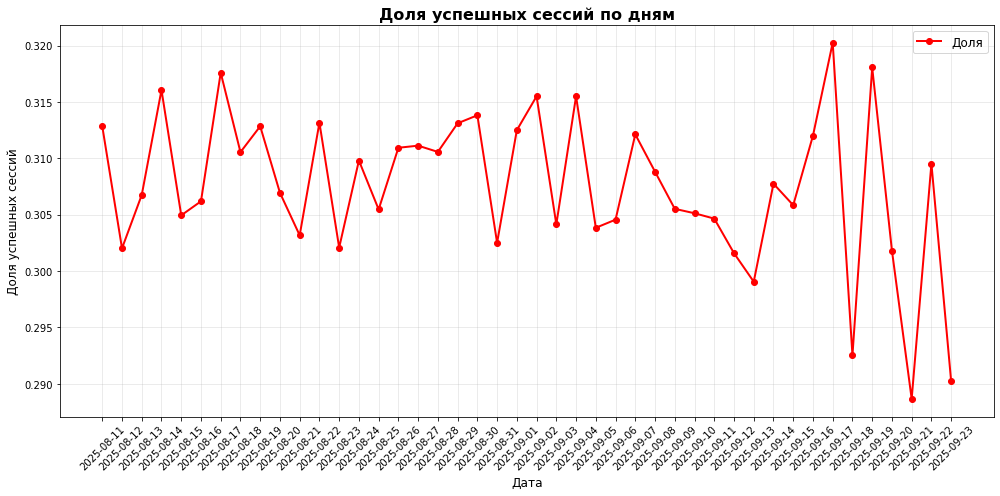

In [12]:
df_good = df.groupby('session_date')['good_session'].sum()
df_all = df.groupby('session_date')['session_id'].count()
df_part2 = df_good / df_all

plt.figure(figsize=(14, 7))

plt.plot(df_part2.index, df_part2.values, 
         label='Доля', 
         marker='o', 
         linewidth=2,
         color='red')

# Настройки графика
plt.title('Доля успешных сессий по дням', fontsize=16, fontweight='bold')
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Доля успешных сессий', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

<div class="alert alert-block alert-success">

Комментарии к графику:
    
На графике представлена доля успешных сессий по дням в наблюдаемом периоде. 

Несмотря на нестабильный вид графика, значений долей успешных сессий по дням в основном находятся в интервале от 0.29 до 0.32. 
    
Максимальная доля успешных сессий была 16.09.2025. 
    
Минимальная доля успешных сессий была 20.09.2025г. 

<!-- ✅⚠️⛔❌🚩 -->
<div style="background-color: white; border: 2px solid black; border-radius: 20px; padding: 15px 25px; display: inline-block; color: black;">

##### ✅  Доля пользователей, просмотревших более четырёх страниц

---

✅ График правильный.

    
---

⚠️ Нет самого анализа - Представлен только код, но не сделаны выводы. Лучше добавить хотя бы 2–3 предложения с интерпретацией.     

---

💬 Здесь можно оставить комментарий
    

✅ Можно также учитывать возможную цикличность активности пользователей, чтобы точнее планировать тесты.    

### 2. Подготовка к тесту
При планировании теста необходимо проделать несколько важных шагов:

- Сформулировать нулевую и альтернативную гипотезы

- Определиться с целевой метрикой.

- Рассчитать необходимый размер выборки.

- Исходя из текущих значений трафика рассчитать необходимую длительность проведения теста.

#### 2.1 Формулировка нулевой и альтернативной гипотез

Перед тем как проводить А/B-тест, необходимо сформулировать нулевую и альтернативную гипотезы. Напомним изначальное условие: команда разработчиков рекомендательных систем создала новый алгоритм, который, по их мнению, будет показывать более интересный контент для каждого пользователя.

О какой метрике идёт речь? Как она будет учтена в формулировке гипотез?


Сформулируйте нулевую и альтернативную гипотезы:

Исследуемая метрика: Кол-во успешных сессий (более 4 страниц)

Нулевая гипотеза (H₀)
Новый алгоритм не повлиял на кол-во успешных сессий

Альтернативная гипотеза (H₁)
Новый алгоритм увеличил кол-во успешных сессий (правосторонняя альтернативная гипотеза)




<div style="background-color: white; border: 2px solid black; border-radius: 20px; padding: 15px 25px; display: inline-block; color: black;">

##### ✅ Формулировка гипотез перед статистическим тестом

---

✅ Молодец, что перед проверкой теста  формулируешь нулевую (H₀) и альтернативную (H₁) гипотезы. Так понятно, какие различия мы проверяем.


Подробнее можно почитать [здесь](https://allatambov.github.io/psms/pdf/hypo-test.pdf)  

#### 2.2. Расчёт размера выборки
В рамках курса вы уже рассчитывали размеры выборки и  использовали для этого онлайн-калькулятор. В этом задании предлагаем воспользоваться готовым кодом и рассчитать необходимое для вашего эксперимента количество пользователей.

Для этого установите в коде ниже следующие параметры:

- Уровень значимости — 0.05.

- Вероятность ошибки второго рода — 0.2.

- Мощность теста.

- Минимальный детектируемый эффект, или MDE, — 3%. Обратите внимание, что здесь нужно указать десятичную дробь, а не процент.

При расчёте размера выборки используйте метод `solve_power()` из класса `power.NormalIndPower` модуля `statsmodels.stats`.

Запустите ячейку и изучите полученное значение.

In [13]:
# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 1 - beta  # Мощность теста
p = 0.3 # Базовый уровень доли
mde = 0.03 * p  # Минимальный детектируемый эффект
effect_size = proportion_effectsize(p, p + mde)

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = effect_size,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 41040


<!-- ✅⚠️⛔❌🚩 -->
<div style="background-color: white; border: 2px solid black; border-radius: 20px; padding: 15px 25px; display: inline-block; color: black;">

##### ✅  Расчёт размера выборки

---

⛔️ В формуле минимального детектируемого эффекта установлено mde = 0.03, что эквивалентно 3 процентным пунктам, а не 3% от базового уровня. Для корректности нужно задать mde как 3% от значения p.
    
Ориентир: 41040    

---

💬 Здесь можно оставить комментарий
    
---
    
✅ Верно.    

#### 2.3. Расчёт длительности A/B-теста

Используйте данные о количестве пользователей в каждой выборке и среднем количестве пользователей приложения. Рассчитайте длительность теста, разделив одно на другое.

- Рассчитайте среднее количество уникальных пользователей приложения в день.

- Определите длительность теста исходя из рассчитанного значения размера выборок и среднего дневного трафика приложения. Количество дней округлите в большую сторону.

In [14]:
# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = df.groupby('session_date')['user_id'].nunique().mean()
print(avg_daily_users)
# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(sample_size*2 / avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровне трафика в {avg_daily_users} пользователей в день составит {test_duration} дней")

9907.363636363636
Рассчитанная длительность A/B-теста при текущем уровне трафика в 9907.363636363636 пользователей в день составит 9 дней


<!-- ✅⚠️⛔❌🚩 -->
<div style="background-color: white; border: 2px solid black; border-radius: 20px; padding: 15px 25px; display: inline-block; color: black;">


##### ✅ Расчёт среднего числа пользователей в день

---

✅ По коду все верно.

---

⚠️ Но после корректировки размера выборки здесь результат тоже изменится.

---

💬 Здесь можно оставить комментарий
    
---
    
✅ Все правильно, но важно понимать, что это допустимый минимальный срок, однако для повышения надёжности результатов теста желательно провести его дольше — например, на 14 дней, чтобы сгладить возможные колебания в поведении пользователей по дням недели и собрать больше данных для анализа.    
    
В нашем случае тест длится - 20 дней, за счёт чего общее число участников увеличивается. Поэтому мощность теста остаётся высокой — 99.97%. Это значит, что вероятность не заметить реальный эффект крайне мала.    

### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей

A/B-тест успешно запущен, и уже доступны данные за первые три дня. На этом этапе нужно убедиться, что всё идёт хорошо: пользователи разделены правильным образом, а интересующие вас метрики корректно считаются.

- Считайте и сохраните в датафрейм `sessions_test_part` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test_part.csv`.

- Рассчитайте количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения.

- Рассчитайте и выведите на экран процентную разницу в количестве пользователей в группах A и B. Постройте любую удобную визуализацию, на которой будет видно возможное различие двух групп.

Для расчёта процентной разницы воспользуйтесь формулой:
$$P = 100 \cdot  \frac{|A − B|}{A}$$

In [15]:
try:
    sessions_test_part = pd.read_csv("https://code.s3.yandex.net/datasets/sessions_project_test_part.csv")
    print("Файл успешно загружен")
    print(f"Размер данных: {df.shape}")
    
except FileNotFoundError:
    print("Ошибка: Файл не найден! Проверьте путь к файлу.")
    
display(sessions_test_part.head(5))

Файл успешно загружен
Размер данных: (435924, 11)


,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,3404844B53442747,B4901323BD537E45,2025-10-14,2025-10-14 19:28:49,2025-10-14,1,0,3,CIS,Android,B
1,3A2BF4D364E62D89,216FC619308F8788,2025-10-14,2025-10-14 21:11:04,2025-10-14,1,0,3,MENA,iPhone,A
2,79CDAE11E32B1597,EDFCE4AC1A504074,2025-10-14,2025-10-14 21:44:03,2025-10-14,1,0,3,CIS,iPhone,A
3,D6AF8D78297A931F,CF0AC0EEDE92C690,2025-10-14,2025-10-14 19:07:55,2025-10-14,1,0,4,CIS,PC,A
4,37E0CE723AE568E0,2E6ED45E8C86C4E9,2025-10-14,2025-10-14 15:39:44,2025-10-14,1,0,3,CIS,Mac,B


In [16]:
daily_users_by_group = sessions_test_part.groupby('test_group')['user_id'].nunique()
display(daily_users_by_group)

test_group
A    1477
B    1466
Name: user_id, dtype: int64

In [17]:
count_a = sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id'].nunique()
count_b = sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id'].nunique()
display(count_a)
display(count_b)

1477

1466

In [18]:
distinction = (abs(count_a - count_b) / count_a)*100
display(distinction)

0.7447528774542992

<AxesSubplot:title={'center':'Кол-во уникальных пользователей в группах А и В'}, xlabel='test_group', ylabel='Кол-во пользователей'>

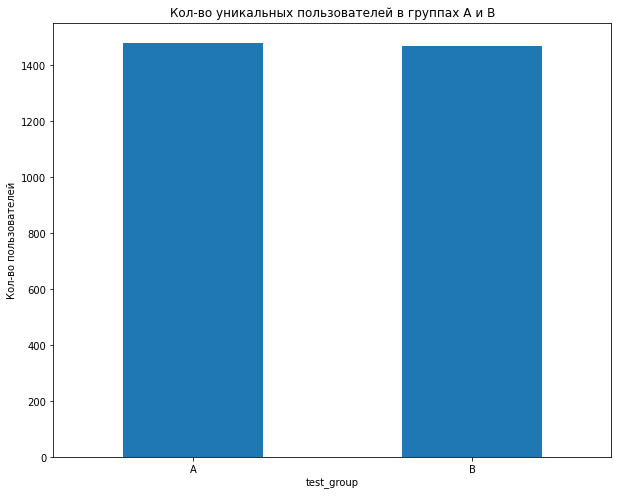

In [19]:
daily_users_by_group.plot(
    kind = 'bar',
    title = 'Кол-во уникальных пользователей в группах А и В',
    figsize = (10, 8),
    rot = 0,
    ylabel = 'Кол-во пользователей')

<div class="alert alert-block alert-success">
Вывод: кол-во пользователей в обеих выборках незначительно отличается (0.74%), что говорит о том, что мы имеем дело с отличным распределением.

<div style="background-color: white; border: 2px solid black; border-radius: 20px; padding: 15px 25px; display: inline-block; color: black;">

##### ✅ Проверка распределения пользователей

---

✅ Эта проверка важна по нескольким причинам:
    
- Правильность разделения пользователей: Чтобы результат A/B-теста был корректным, важно убедиться, что группы A и B были случайным образом разделены, а не случайным образом или по какому-либо смещённому принципу. Если группы не были равномерно разделены, это может привести к ошибочным выводам, так как различия в поведении пользователей могут быть вызваны не тестируемым фактором, а изначальной неоднородностью групп.
- Корректность расчёта метрик: Мы проверяем, что метрики, такие как количество уникальных пользователей, корректно считаются для каждой из групп. Это важно, потому что любые ошибки в учёте пользователей могут исказить результаты теста и привести к неверным выводам о влиянии изменений на поведение пользователей.
- Обнаружение аномалий: Если процентная разница в количестве пользователей между группами слишком велика, это может свидетельствовать о проблемах с разделением пользователей, таких как технические ошибки или неправильное распределение. Проверка позволяет выявить такие аномалии на ранних стадиях теста и скорректировать процесс.
- Убедительность результатов: Важно, чтобы тест был честным и справедливым. Если группа A имеет значительное преимущество по численности, то результаты могут быть искажены. Это проверка помогает удостовериться, что эксперимент был проведён корректно, и что его результаты можно использовать для объективных выводов.

#### 3.2. Проверка пересечений пользователей
Помимо проверки равенства количества пользователей в группах, полезно убедиться в том, что группы независимы. Для этого нужно убедиться, что никто из пользователей случайно не попал в обе группы одновременно.

- Рассчитайте количество пользователей, которые встречаются одновременно в группах A и B, или убедитесь, что таких нет.

In [20]:
users_in_a = set(sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id'].unique())
users_in_b = set(sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id'].unique())
share_users = users_in_a.intersection(users_in_b)
if len(share_users) == 0:
    print("Нет пользователей, которые встречаются в обеих группах") 
else:
    print(f"Количество пользователей в обеих группах: {len(share_users)}")

Нет пользователей, которые встречаются в обеих группах


<div style="background-color: white; border: 2px solid black; border-radius: 20px; padding: 15px 25px; display: inline-block; color: black;">

##### ✅ Проверка пересечений пользователей между группами

---

✅ Альтернативный способ — использовать группировку, что может быть полезно при работе с большими данными:

```py
(sessions_test_part
 .groupby('user_id')
 .agg({'test_group':'nunique'})
 .query('test_group > 1'))
```

Этот метод позволяет сразу отфильтровать пользователей, которые встречаются в обеих группах.

#### 3.3. Равномерность разделения пользователей по устройствам
Полезно также убедиться в том, что пользователи равномерно распределены по всем доступным категориальным переменным — типам устройств и регионам.

Постройте две диаграммы:

- доля каждого типа устройства для пользователей из группы A,

- доля каждого типа устройства для пользователей из группы B.

Постарайтесь добавить на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение устройств в группах A и B.


In [21]:
df_group_a = sessions_test_part[sessions_test_part['test_group'] == 'A']
df_device_a = df_group_a.groupby('device')['user_id'].nunique()
display(df_device_a)

device
Android    656
Mac        156
PC         369
iPhone     296
Name: user_id, dtype: int64

In [22]:
df_part_a = df_device_a / count_a
display(df_part_a)

device
Android    0.444144
Mac        0.105619
PC         0.249831
iPhone     0.200406
Name: user_id, dtype: float64

In [23]:
df_group_b = sessions_test_part[sessions_test_part['test_group'] == 'B']
df_device_b = df_group_b.groupby('device')['user_id'].nunique()
display(df_device_b)

device
Android    668
Mac        148
PC         381
iPhone     269
Name: user_id, dtype: int64

In [24]:
df_part_b = df_device_b / count_b
display(df_part_b)

device
Android    0.455662
Mac        0.100955
PC         0.259891
iPhone     0.183492
Name: user_id, dtype: float64

In [25]:
df_comparison = pd.concat([df_part_a, df_part_b], axis=1, keys=['Доля A', 'Доля B']).fillna(0)

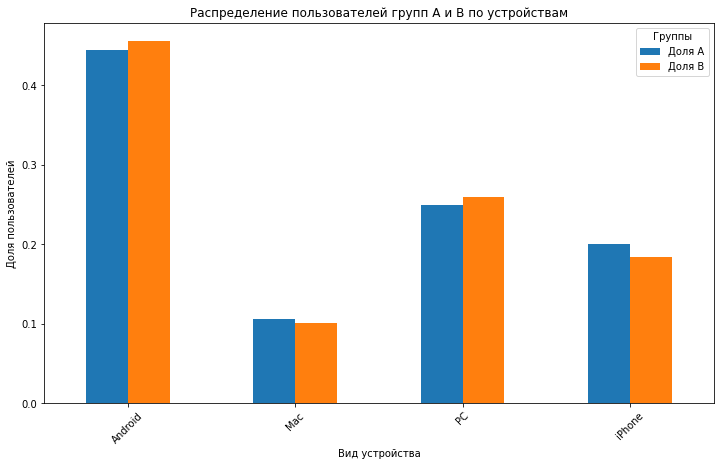

In [26]:
ax = df_comparison.plot(kind='bar', figsize=(12, 7))

plt.xlabel('Вид устройства')
plt.ylabel('Доля пользователей')
plt.title('Распределение пользователей групп А и В по устройствам')

# Показываем график
plt.xticks(rotation=45)
plt.legend(title='Группы')
plt.show()

<div class="alert alert-block alert-success">
Вывод: кол-во пользователей в обеих выборках незначительно отличается, что говорит о том, что пользователи обеих выборок нормально распределены.

#### 3.4. Равномерность распределения пользователей по регионам
Теперь убедитесь, что пользователи равномерно распределены по регионам.

Постройте две диаграммы:

- доля каждого региона для пользователей из группы A,

- доля каждого региона для пользователей из группы B.

Постарайтесь добавить на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение регионов в группах A и B. Постарайтесь использовать другой тип диаграммы, не тот, что в прошлом задании.


In [27]:
df_region_a = df_group_a.groupby('region')['user_id'].nunique()
display(df_region_a)

region
CIS     644
EU      224
MENA    609
Name: user_id, dtype: int64

In [28]:
df_part_a1 = df_region_a / count_a
display(df_part_a1)

region
CIS     0.436019
EU      0.151659
MENA    0.412322
Name: user_id, dtype: float64

In [29]:
df_region_b = df_group_b.groupby('region')['user_id'].nunique()
display(df_region_b)

region
CIS     645
EU      217
MENA    604
Name: user_id, dtype: int64

In [30]:
df_part_b1 = df_region_b / count_b
display(df_part_b1)

region
CIS     0.439973
EU      0.148022
MENA    0.412005
Name: user_id, dtype: float64

In [31]:
df_comparison1 = pd.concat([df_part_a1, df_part_b1], axis=1, keys=['Доля A', 'Доля B']).fillna(0)

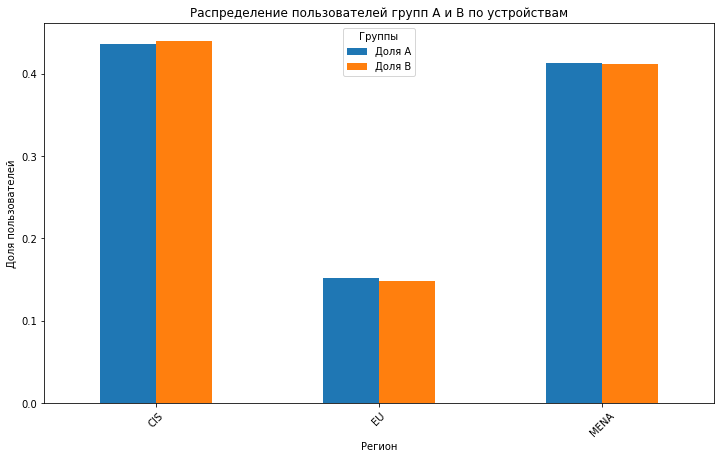

In [32]:
ax1 = df_comparison1.plot(kind='bar', figsize=(12, 7))

plt.xlabel('Регион')
plt.ylabel('Доля пользователей')
plt.title('Распределение пользователей групп А и В по устройствам')

# Показываем график
plt.xticks(rotation=45)
plt.legend(title='Группы')
plt.show()

<div class="alert alert-block alert-success">
Вывод: кол-во пользовательей в обеих выборках незначительно отличается, что говорит о том, что пользователи обеих выборок нормально распределены.

<!-- ✅⚠️⛔❌🚩 -->
<div style="background-color: white; border: 2px solid black; border-radius: 20px; padding: 15px 25px; display: inline-block; color: black;">

##### ✅ Равномерность разделения 

---

✅ Все правильно, обязательно стоит проверять равномерность распределения, даже если в целом группы получились почти 50/50 по пользователям.

Проверка равномерности по количеству пользователей в группах это один срез, но распределение по устройствам/регионам это уже другие факторы, которые могут повлиять на поведение пользователей. 

Например, пользователи Android и iOS могут по-разному конвертировать или тратить деньги.

Даже при идеально ровном делении пользователей (50/50) может оказаться, что в одной группе больше пользователей с iPhone, а в другой с Android. И вот тогда уже не ясно: различие в метриках возникло из-за A/B-теста или из-за устройства?

#### 3.5. Вывод после проверки A/B-теста

На основе проведённого анализа A/B-теста сформулируйте и запишите свои выводы. В выводе обязательно укажите:

- Было ли обнаружено различие в количестве пользователей в двух группах.

- Являются ли выборки независимыми. Было ли обнаружено пересечение пользователей из тестовой и контрольной групп.

- Сохраняется ли равномерное распределение пользователей тестовой и контрольной групп по категориальным переменным: устройствам и регионам.

Сделайте заключение: корректно ли проходит A/B-тест, или наблюдаются какие-либо нарушения.

<div class="alert alert-block alert-success">
    
**Вывод:**
    
1. Кол-во пользователей в обеих выборках незначительно отличается (0.74%), что говорит о том, что мы имеем дело с отличным распределением.
2. Пользователей, которые бы были одновременно в двух группах не обнаружено, что говорит не зависимости обеих выборок. 
3. Исходя из анализа по регионам и устройствам видно, что кол-во пользователей каждой из групп распределено нормально. 

**Резюмируя вышеописанное, можно утверждать, что А/И тест проходит нормально, нарушений не наблюдается.**

<div style="background-color: white; border: 2px solid black; border-radius: 20px; padding: 15px 25px; display: inline-block; color: black;">

##### ✅ Вывод по результатам A/B-теста

--- 

✅ Хорошо, можно переходить к проверке результатов A/B-теста.

### 4. Проверка результатов A/B-теста

A/B-тест завершён, и у вас есть результаты за все дни проведения эксперимента. Необходимо убедиться в корректности теста и верно интерпретировать результаты.

#### 4.1. Получение результатов теста и подсчёт основной метрики

- Считайте и сохраните в датафрейм `sessions_test` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test.csv`.

- В датафрейме `sessions_test` создайте дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если просмотрено меньше.

In [33]:
try:
    sessions_test = pd.read_csv("https://code.s3.yandex.net/datasets/sessions_project_test.csv")
    print("Файл успешно загружен")
    print(f"Размер данных: {df.shape}")
    
except FileNotFoundError:
    print("Ошибка: Файл не найден! Проверьте путь к файлу.")
    
display(sessions_test.head(5))

Файл успешно загружен
Размер данных: (435924, 11)


,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B


In [34]:
sessions_test['good_session'] = (sessions_test['page_counter'] >= 4).astype(int)
display(sessions_test.head(10))

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group,good_session
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A,0
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B,0
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A,0
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B,0
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B,0
5,31F7A42B32103403,E9B64B779C3348ED,2025-10-20,2025-10-20 17:09:41,2025-10-19,2,0,2,CIS,PC,B,0
6,87C09E3E3B334959,FECFF83C13DC9364,2025-10-22,2025-10-22 23:51:42,2025-10-20,3,0,4,CIS,iPhone,B,1
7,457F2674E87EF6E7,14F71C18BE2CEC08,2025-10-19,2025-10-19 11:49:11,2025-10-19,1,0,3,MENA,Mac,A,0
8,57F342451921D207,76EFA055599ADE3C,2025-10-19,2025-10-19 18:47:43,2025-10-19,1,0,3,CIS,PC,A,0
9,3404844B53442747,B4901323BD537E45,2025-10-14,2025-10-14 19:28:49,2025-10-14,1,0,3,CIS,Android,B,0


#### 4.2. Проверка корректности результатов теста

Прежде чем приступать к анализу ключевых продуктовых метрик, необходимо убедиться, что тест проведён корректно и вы будете сравнивать две сопоставимые группы.

- Рассчитайте количество уникальных сессий для каждого дня и обеих тестовых групп, используя группировку.

- Проверьте, что количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимыми. Используйте статистический тест, который позволит сделать вывод о равенстве средних двух выборок.

- В качестве ответа выведите на экран полученное значение p-value и интерпретируйте его.

<!-- ✅⚠️⛔❌🚩 -->
<div style="background-color: white; border: 2px solid black; border-radius: 20px; padding: 15px 25px; display: inline-block; color: black;">

##### ⚠️ Формулировка гипотез перед статистическим тестом

---

⚠️ Проверяется то, чего нет. 😉 Сформулированные гипотезы — это часть теста.


Важно **перед** проверкой теста (кодом) формулировать нулевую (H₀) и альтернативную (H₁) гипотезы, чтобы было понятно, какие различия мы проверяем.

В шаге 2.1 нулевая и альтернативная гипотезы сформулированы не для текущего шага, а для шага 4.4, где оценивается статистическая значимость изменения ключевой метрики.

В нулевой гипотезе обычно утверждают отсутствие эффекта или различий (например, "равны" или "не отличаются"), а альтернативная гипотеза (H₁) предполагают наличие эффекта или различия (например, "отличаются", "больше" или "меньше").
    
Если направление не задано, то:   
* H₀ - равны;   
* H₁ - отличаются.   

**Значит**:

- H₀ (нулевая гипотеза) — количество уникальных дневных сессий `не различается` между тестовой и контрольной группами.
- H₁ (альтернативная гипотеза) — количество уникальных дневных сессий `различается` между тестовой и контрольной группами.

    
На будущее: Значения nan, 0 и 1 первый признак некорректного расчета, это может указывать на проблемы в расчётах или наличие идентичных или вырожденных данных.    
    
Подробнее можно почитать [здесь](https://allatambov.github.io/psms/pdf/hypo-test.pdf)    


---

💬 Здесь можно оставить комментарий
    
    
    
    Не очень понимаю какую гипотезу нужно сформировать в пункте 2.1. Сначала я думал, что ключевой метрикой должно быть DAU, однако для DAU не подходил дальнейший расчет размера выборки и групп А и В. 
    
---
    
⚠️ Подсказка
    
Смотри, здесь мы провеяем:
    
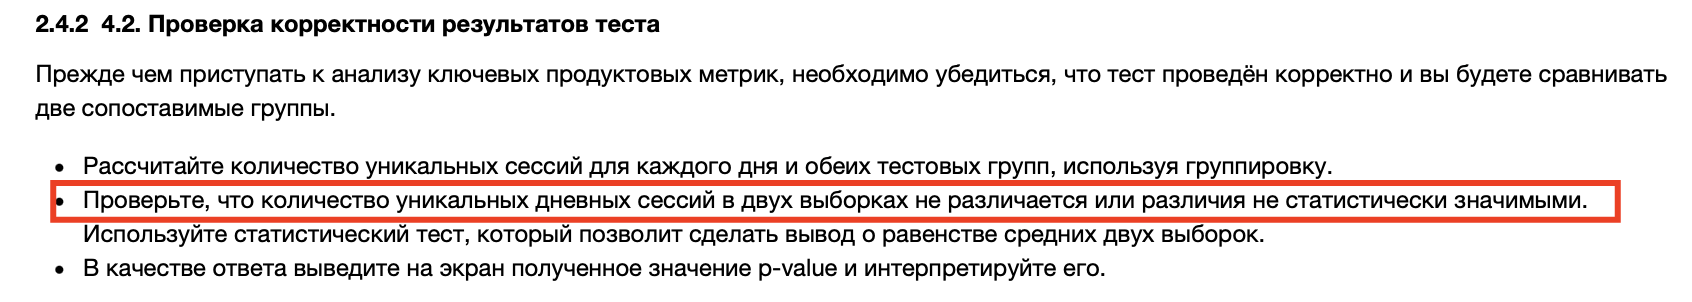    

Исследуемая метрика: Кол-во успешных сессий (более 4 страниц) по дням для каждой выборки 

Нулевая гипотеза (H₀)
Между выборками А и В нет значимых различий по количеству уникальных сессий для каждого дня

Альтернативная гипотеза (H₁)
Между выборками А и В присутствуют значимые различия по количеству уникальных сессий для каждого дня

In [35]:
df_gr = sessions_test.groupby(['session_date', 'test_group'])['session_id'].nunique()
display(df_gr)

session_date  test_group
2025-10-14    A             1502
              B             1628
2025-10-15    A             2235
              B             2283
2025-10-16    A             3280
              B             3241
2025-10-17    A             4089
              B             4054
2025-10-18    A             5013
              B             5059
2025-10-19    A             6535
              B             6779
2025-10-20    A             5837
              B             6089
2025-10-21    A             3927
              B             3981
2025-10-22    A             3083
              B             3111
2025-10-23    A             2470
              B             2548
2025-10-24    A             2090
              B             2068
2025-10-25    A             1897
              B             1814
2025-10-26    A             1669
              B             1692
2025-10-27    A             1454
              B             1517
2025-10-28    A             1279
              B   

In [36]:
df_gr = sessions_test.groupby(['session_date', 'test_group'])['session_id'].nunique().reset_index()
df_gr.columns = ['session_date', 'test_group', 'sessions_per_day']

metric_a=df_gr[df_gr['test_group'] == 'A']['sessions_per_day']
metric_b=df_gr[df_gr['test_group'] == 'B']['sessions_per_day']


alpha = 0.05 

stat_ttest, p_value_ttest = ttest_ind(
    metric_a,
    metric_b,
    alternative= 'two-sided'
)
print(f'pvalue={p_value_ttest}')

if p_value_ttest > alpha:
    print('Между выборками А и В нет значимых различий')
else:
    print('Между выборками А и В присутствуют различия')

pvalue=0.938219304859116
Между выборками А и В нет значимых различий


#### 4.3. Сравнение доли успешных сессий

Когда вы убедились, что количество сессий в обеих выборках не различалось, можно переходить к анализу ключевой метрики — доли успешных сессий.

Используйте созданный на первом шаге задания столбец `good_session` и рассчитайте долю успешных сессий для выборок A и B, а также разницу в этом показателе. Полученный вывод отобразите на экране.

In [37]:
df_good_a = sessions_test[(sessions_test['test_group'] == 'A')&(sessions_test['good_session'] == 1)]['session_id'].nunique()
df_all_a = sessions_test[sessions_test['test_group'] == 'A']['session_id'].nunique()
df_part_good_a = df_good_a / df_all_a
display(df_part_good_a)

0.3077233557344958

In [38]:
df_good_b = sessions_test[(sessions_test['test_group'] == 'B')&(sessions_test['good_session'] == 1)]['session_id'].nunique()
df_all_b = sessions_test[sessions_test['test_group'] == 'B']['session_id'].nunique()
df_part_good_b = df_good_b / df_all_b
display(df_part_good_b)

0.31828992745867524

In [39]:
df_dis = abs(df_part_good_a - df_part_good_b)
print(f'Разница={df_dis}. Разница долей успешных сессий в обеих группах практически не отличается.')

Разница=0.010566571724179463. Разница долей успешных сессий в обеих группах практически не отличается.


<div style="background-color: white; border: 2px solid black; border-radius: 20px; padding: 15px 25px; display: inline-block; color: black;">

##### ✅ Расчёт доли успешных сессий

---

✅ Все правильно 1%. Сравнение доли успешных сессий это важный шаг, потому что именно эта метрика показывает, насколько эффективно пользователи достигают целевого действия при взаимодействии с продуктом.
 
Если доля успешных сессий в одной из групп выше, это может говорить о том, что изменения, протестированные в этой группе, положительно повлияли на пользовательский опыт. А значит, они могут быть внедрены в основную версию продукта.

Без такой проверки невозможно оценить реальное влияние нововведения, даже если распределение сессий по группам было корректным.

#### 4.4. Насколько статистически значимо изменение ключевой метрики

На предыдущем шаге вы убедились, что количество успешных сессий в тестовой выборке примерно на 1.1% выше, чем в контрольной, но делать выводы только на основе этого значения будет некорректно. Для принятия решения всегда необходимо отвечать на вопрос: является ли это изменение статистически значимым.

- Используя статистический тест, рассчитайте, является ли изменение в метрике доли успешных сессий статистически значимым.

- Выведите на экран полученное значение p-value и свои выводы о статистической значимости. Напомним, что уровень значимости в эксперименте был выбран на уровне 0.05.

In [40]:
n_a = sessions_test[sessions_test['test_group'] == 'A']['session_id'].nunique()
n_b = sessions_test[sessions_test['test_group'] == 'B']['session_id'].nunique()
display(n_a, n_b)

49551

50454

In [41]:
m_a = sessions_test[(sessions_test['test_group'] == 'A')&(sessions_test['good_session'] == 1)]['session_id'].nunique()
m_b = sessions_test[(sessions_test['test_group'] == 'B')&(sessions_test['good_session'] == 1)]['session_id'].nunique()
display(m_a, m_b)

15248

16059

<!-- ✅⚠️⛔❌🚩 -->
<div style="background-color: white; border: 2px solid black; border-radius: 20px; padding: 15px 25px; display: inline-block; color: black;">

##### ⚠️ Формулировка гипотез перед статистическим тестом

---

⚠️ Подсказка:
    
А здесь:
    
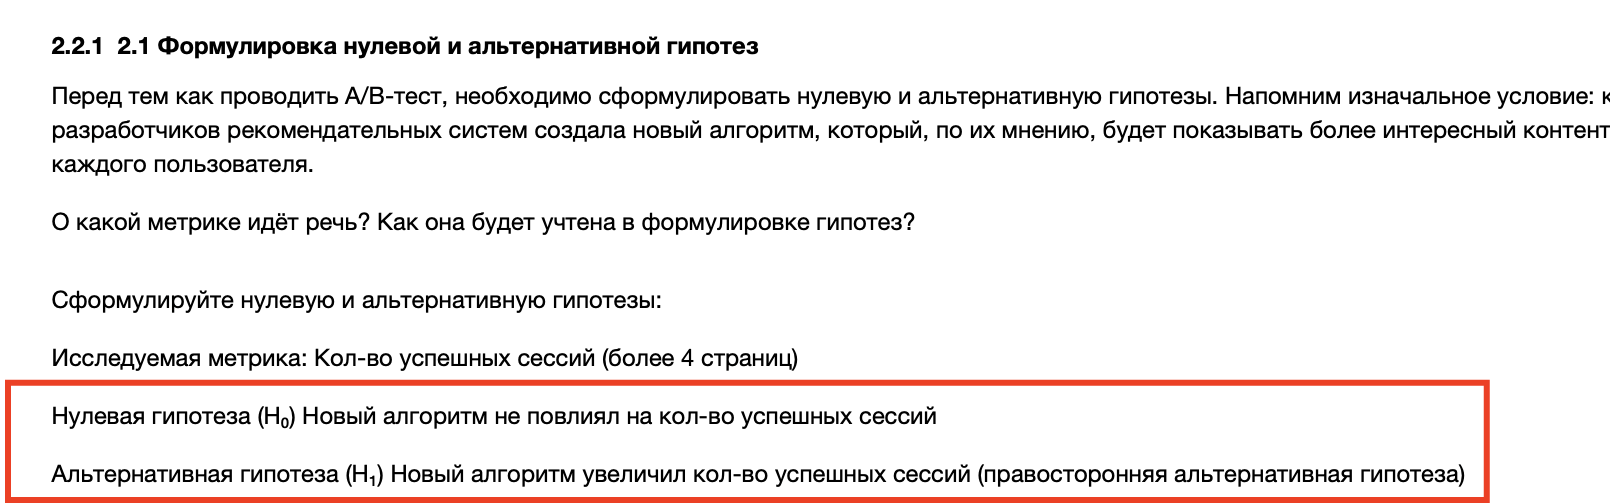    

In [42]:
alpha = 0.05

stat_ztest, p_value_ztest = proportions_ztest(
    [m_b, m_a],
    [n_b, n_a],
    alternative='larger'
)

if p_value_ztest > alpha:
    print(f'pvalue={p_value_ztest} > {alpha}')
    print('Наблюдаемое изменение в метрики доли не является статистически значимым')
else:
    print(f'pvalue={p_value_ztest} < {alpha}')
    print('Наблюдаемое изменение в метрики доли является статистически значимым')

pvalue=0.0001574739988036123 < 0.05
Наблюдаемое изменение в метрики доли является статистически значимым


<div class="alert alert-block alert-success">
    
Исправил порядок параметров теста.

<!-- ✅⚠️⛔❌🚩 -->
<div style="background-color: white; border: 2px solid black; border-radius: 20px; padding: 15px 25px; display: inline-block; color: black;">

##### ✅ Насколько статистически значимо изменение ключевой метрики

----
    

    
⚠️ Нас интересует не просто разница, а улучшение, так как разница может быть и в худшую сторону. 
    
*Напомним изначальное условие: команда разработчиков рекомендательных систем создала новый алгоритм, который, по их мнению, будет показывать **более интересный контент** для каждого пользователя.*
    
---

**🔘 Дано**
- B — метрика в **тестовой группе**. Это группа, на которой проводится эксперимент или изменение.     
- A — метрика в **контрольной группе**. Это группа, которая не подвергается изменению. Она служит для сравнения, чтобы понять, как изменение в тестовой группе повлияло на результаты. 

---

**Порядок аргументов (имеет значение) - Так должно быть. ✅**

Например, если ты проверяешь: B > A, то порядок аругуметов такой:

`test(B, A, alternative='greater/larger')`

**Тестовая группа идет всегд первой, контрольная второй.**

Если ты случайно поменяешь местами группы, изменится смысл теста.

---

**Проверка на увеличение (cтало лучше или больше) - Так должно быть. ✅**

- H₀: B ≤ A
- H₁: μA > A

`test(B, A, alternative='greater/larger')`

Применяй, если ожидаешь, что B больше чем A.

---

**Проверка на различие (двусторонняя) - Так сейчас в коде. ⚠️**

- H₀: B = A
- H₁: B ≠ A

`test(μA, A, alternative='two-sided')` (по умолчанию в большинстве библиотек)

Применяй, если не знаешь, в какую сторону будет отличие.
    
    

#### 4.5. Вывод по результатам A/B-эксперимента

На основе проведённого анализа результатов теста сформулируйте и запишите свои выводы для команды разработки приложения. В выводе обязательно укажите:

- Характеристики проведённого эксперимента, количество задействованных пользователей и длительность эксперимента.

- Повлияло ли внедрение нового алгоритма рекомендаций на рост ключевой метрики и как.

- Каким получилось значение p-value для оценки статистической значимости выявленного эффекта.

- Стоит ли внедрять нововведение в приложение.

<div class="alert alert-block alert-success">

1. Эксперимент был проведён в форме A/B-теста с равномерным распределением пользователей между контрольной (группа A) и тестовой (группа B) группами. Рандомизация осуществлялась на уровне уникального пользователя, при этом каждый пользователь участвовал только в одной из групп на протяжении всего периода тестирования. 

Длительность эксперимента: 9 полных дней. <br>

Общее количество задействованных пользователей: X уникальных пользователей, из них:<br>

группа A (контроль): 1477 пользователей,<br>

группа B (тест): 1466 пользователей.<br>

2. Исходя из проделанных статистических тестов было выявлено, что наблюдаемое изменение метрики (доля успешных сессий) в размере 1.1% является статистически значимой, что говорит об большой вероятности успеха в случае внедрения нового алгоритма. 

3. При оценке статистической значимости **pvalue** получилось = 0.00015, что меньше уровня значимости **alpha** = 0.05. Это говорит о том, что наблюдаемое изменение ключевой метрики является статистически значимым.

4. В результате проделанной работы можно сделать вывод, что алгоритм стоит внедрять в новых версиях приложения.

<div style="background-color: white; border: 2px solid black; border-radius: 20px; padding: 15px 25px; display: inline-block; color: black;">

##### ✅ Итоговый аналитический вывод

---
     
✅ Правильный расчет. Видно, что метрика улучшилась, и тест это подтвердил, что говорит об успешности A/B-эксперимента! 🎯   
    
---
    
⚠️ В нашем случае тест длится - 20 дней, за счёт чего общее число участников увеличивается. Поэтому мощность теста остаётся высокой — 99.97%. Это значит, что вероятность не заметить реальный эффект крайне мала.

---

💬 Здесь можно оставить комментарий

<!-- ✅⚠️⛔❌🚩 -->
<div style="background-color: white; border: 2px solid black; border-radius: 20px; padding: 15px 25px; display: inline-block; color: black;">
    
## 🏁 **Итоги ревью**
<a id="results"></a>
[В начало](#start)

---

⛔️ Руслан, спасибо за работу. Осталось исправить несколько комментариев и можно идти к заказчику. Молодец! 👍
    
Для удобства, комментарии которые нужно скорректировать я добавил в меню **Contents** слева.
    
Жду новую версию проекта. 🙂

---

💬 Здесь можно оставить комментарий

<div style="background-color: black; border: 2px solid #444; border-radius: 20px; padding: 15px 25px; display: inline-block; color: white;">

## ✌️ **Руслан, поздравляю - проект принят!** 🥳 🎉 
    
Ты молодец! 
 
 
🏆 Спасибо за отличную работу! Критических замечаний нет. Ответ на вопрос оставил. Оставил в меню **Contents** (слева) рекомендации. Если у тебя есть вопросы, их можно задать через куратора.

💪 Еще раз спасибо за хорошую работу, твои комментарии и внесенные корректировки! Критических замечаний нет. Если у тебя есть вопросы, их можно задать через куратора.
    
**Успехов в дальнейшем обучении и карьере! 🚀**

**Артем 🤝**    

<img src="https://lifeo.ru/wp-content/uploads/gif-salyut-10.gif"> 
    
---
    
## 📖 **Полезные ссылки**

* [Работа в Яндексе](https://yandex.ru/jobs/pages/analytics_interview?ysclid=l84s63fs1g790141490)
* [Настройте свой Jupyter Notebook правильно](https://medium.com/nuances-of-programming/настройте-свой-jupyter-notebook-правильно-faef14c89434)    
* [PEP 8 – Style Guide for Python Code](https://www.python.org/dev/peps/pep-0008/)    
* [Обработка пропусков в данных](https://loginom.ru/blog/missing)  
* [Разделение данных с помощью qcut и cut в Pandas](https://dfedorov.spb.ru/pandas/Разделение%20данных%20в%20Pandas%20с%20помощью%20qcut%20и%20cut.html?)  
* [Официальная документаци метода qcut](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.qcut.html)  
* [Подробное руководство по группировке и агрегированию с помощью pandas](https://dfedorov.spb.ru/pandas/Подробное%20руководство%20по%20группировке%20и%20агрегированию%20с%20помощью%20pandas.html?ysclid=lcmm6rtg2w602526506)
* [Проверка статистических гипотез. (21 мая 2020 г.)](https://allatambov.github.io/psms/pdf/hypo-test.pdf)    
* [Шпаргалка по визуализации данных в Python с помощью Plotly](https://habr.com/ru/articles/502958/) 
* [Тест гигиены визуализации данных](https://bar-or-pie.dianov.org)    
* [Задачки SQL](https://habr.com/ru/company/dcmiran/blog/500360/)    
* [7 cайтов для оттачивания навыка написания SQL запросов на 2020 год](https://techrocks.ru/2019/11/22/7-sites-to-perfect-sql-query-writing-skills/)
* [Главред помогает очистить текст от словесного мусора, проверяет на соответствие информационному стилю.](https://glvrd.ru)
* [Краткое руководство по Маркдауну](https://paulradzkov.com/2014/markdown_cheatsheet/)

</div>